In [1]:
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Activation, GlobalAveragePooling2D, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pathlib
import random
import shutil

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def safe_unzip(zip_path, extract_to=None):
    """
    Safely unzip a ZIP file.

    Args:
        zip_path (str): Path to the zip file.
        extract_to (str): Folder to extract to.
                          If None, extracts to same directory.

    Returns:
        str or None: Path to extracted folder if successful, otherwise None.
    """
    # Check file exists
    if not os.path.exists(zip_path):
        print(f"❌ ERROR: '{zip_path}' does not exist.")
        return None

    # Check if ZIP is valid
    if not zipfile.is_zipfile(zip_path):
        print(f"❌ ERROR: '{zip_path}' is not a valid zip file or is corrupted.")
        return None

    # Extract target folder
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Try to unzip
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ Unzipped successfully → {extract_to}")
        return extract_to

    except Exception as e:
        print(f"❌ Unzip failed: {e}")
        return None
problem_dir = safe_unzip("/content/Problem_teeth.zip")
no_problem_dir = safe_unzip("/content/No_problem_teeth.zip")


❌ ERROR: '/content/Problem_teeth.zip' does not exist.
❌ ERROR: '/content/No_problem_teeth.zip' does not exist.


In [5]:
classes = ["Problem_teeth", "No_problem_teeth"]
splits = ["train", "test", "val"]

for split in splits:
    for cls in classes:
        os.makedirs(f"dataset/{split}/{cls}", exist_ok=True)

print("Folder structure created!")


Folder structure created!


In [6]:
for dirpath, dirnames, filenames in os.walk('dataset'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 3 directories and 0 images in dataset
There are 2 directories and 0 images in dataset/test
There are 0 directories and 0 images in dataset/test/Problem_teeth
There are 0 directories and 0 images in dataset/test/No_problem_teeth
There are 2 directories and 0 images in dataset/val
There are 0 directories and 0 images in dataset/val/Problem_teeth
There are 0 directories and 0 images in dataset/val/No_problem_teeth
There are 2 directories and 0 images in dataset/train
There are 0 directories and 0 images in dataset/train/Problem_teeth
There are 0 directories and 0 images in dataset/train/No_problem_teeth


In [7]:
# Problem_teeth
old_path = "/content/Problem_teeth/Problem teeth"
new_path = "/content/Problem_teeth/Problem_teeth"
if os.path.exists(old_path):
    os.rename(old_path, new_path)
    print(f"Renamed: {old_path} → {new_path}")
else:
    print(f"Folder already renamed or not found: {old_path}")

# No_problem_teeth
old_path = "/content/No_problem_teeth/No problem teeth"
new_path = "/content/No_problem_teeth/No_problem_teeth"
if os.path.exists(old_path):
    os.rename(old_path, new_path)
    print(f"Renamed: {old_path} → {new_path}")
else:
    print(f"Folder already renamed or not found: {old_path}")

Folder already renamed or not found: /content/Problem_teeth/Problem teeth
Folder already renamed or not found: /content/No_problem_teeth/No problem teeth


View Images from both folders

Selected images: ['/content/drive/MyDrive/Problem_teeth/Problem_teeth/44.tif', '/content/drive/MyDrive/Problem_teeth/Problem_teeth/13.tif', '/content/drive/MyDrive/Problem_teeth/Problem_teeth/3.tif', '/content/drive/MyDrive/Problem_teeth/Problem_teeth/37.tif']
Image shape: (736, 964)
Image shape: (732, 960)
Image shape: (968, 712)
Image shape: (724, 960)


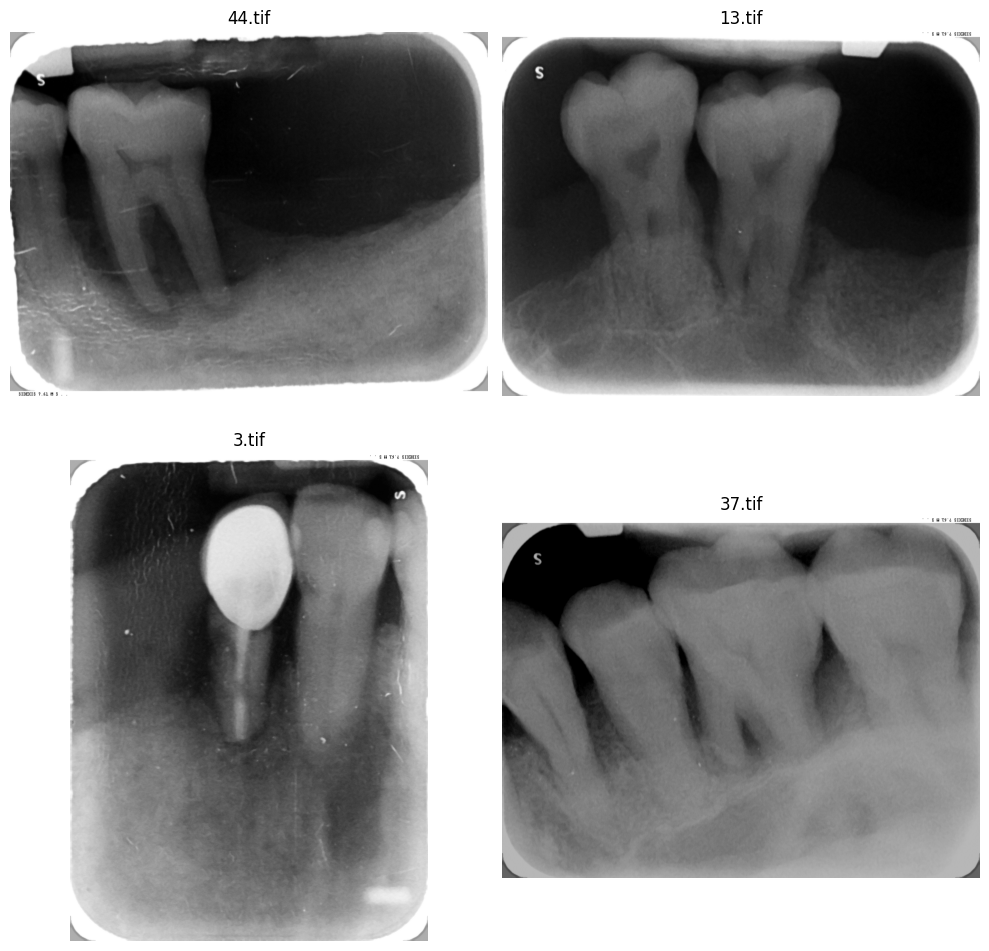

Selected images: ['/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/131.tif', '/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/28.tif', '/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/34.tif', '/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/81.tif']
Image shape: (1468, 1964)
Image shape: (712, 960)
Image shape: (976, 716)
Image shape: (1976, 1456)


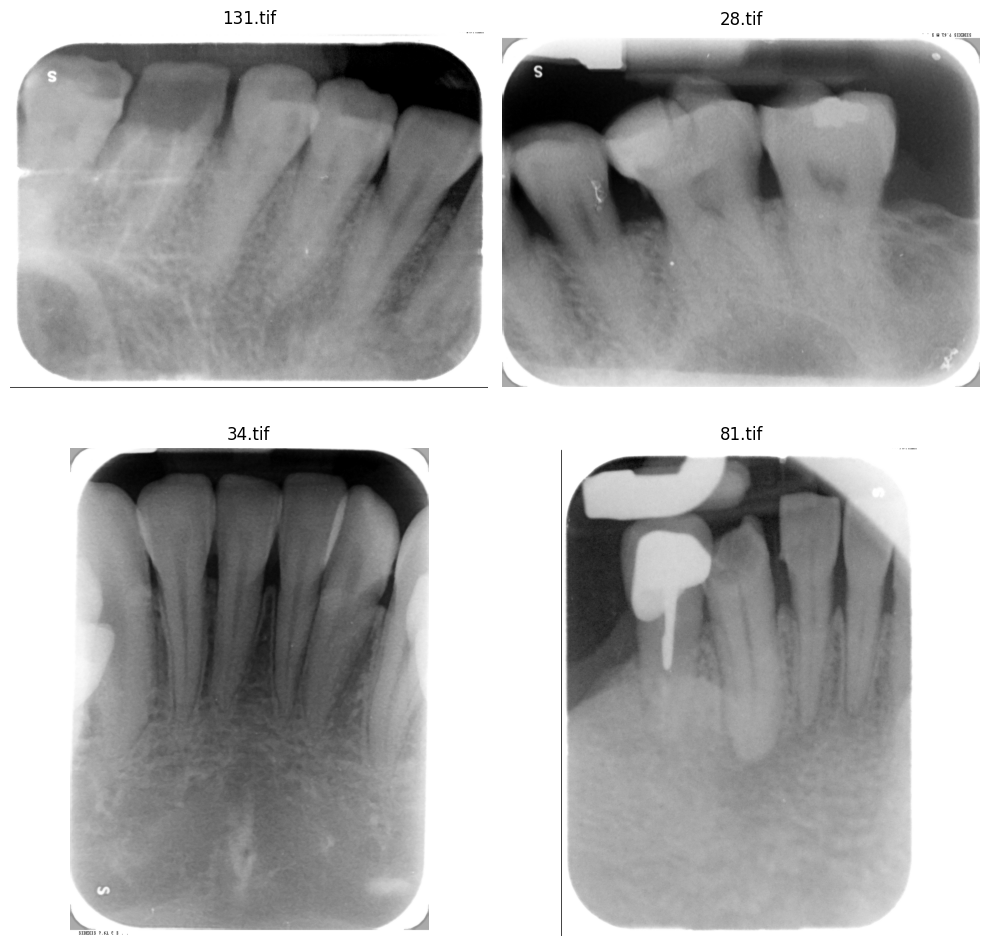

In [8]:
def view_random_images_recursive(folder_path, num_images=4, extensions=(".tif", ".png", ".jpg")):
    """
    Display random images from a folder, recursively handling subfolders.

    Args:
        folder_path (str): Path to the folder containing images or subfolders.
        num_images (int): Number of images to display.
        extensions (tuple): Allowed image extensions.
    """
    # Recursively find all image files
    image_files = []
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith(extensions):
                image_files.append(os.path.join(root, f))

    if not image_files:
        print("No image files found!")
        return

    if num_images > len(image_files):
        num_images = len(image_files)

    random_images = random.sample(image_files, num_images)
    print(f"Selected images: {random_images}")

    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(random_images):
        img = mpimg.imread(img_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(os.path.basename(img_path))
        plt.axis('off')
        print(f"Image shape: {img.shape}")

    plt.tight_layout()
    plt.show()
view_random_images_recursive("/content/drive/MyDrive/Problem_teeth/Problem_teeth", num_images=4)
view_random_images_recursive("/content/drive/MyDrive/No_problem_teeth/No_problem_teeth", num_images=4)

Rotate Images to be in the same format

File: 112.tif



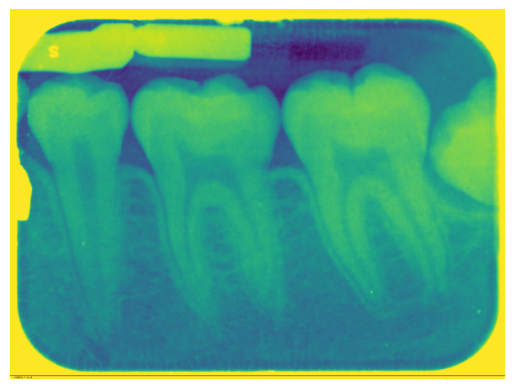

In [9]:
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define folders
NO_PROBLEM = "/content/drive/MyDrive/No_problem_teeth/No_problem_teeth"
PROBLEM = "/content/drive/MyDrive/Problem_teeth/Problem_teeth"

folders = [NO_PROBLEM, PROBLEM]

# Collect all image files
all_files = []
for folder in folders:
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
            all_files.append(os.path.join(folder, fname))

file_iter = iter(all_files)


def process_image(path):
    img = Image.open(path)

    def show():
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    def rotate_right(_):
        nonlocal img
        img = img.rotate(-90, expand=True)
        img.save(path)
        clear_output(wait=True)
        print(f"Rotated right → {os.path.basename(path)}")
        next_image()

    def rotate_left(_):
        nonlocal img
        img = img.rotate(90, expand=True)
        img.save(path)
        clear_output(wait=True)
        print(f"Rotated left → {os.path.basename(path)}")
        next_image()

    def skip(_):
        clear_output(wait=True)
        print(f"Skipped → {os.path.basename(path)}")
        next_image()

    # Buttons
    btn_r = widgets.Button(description="Rotate Right ↪️")
    btn_l = widgets.Button(description="Rotate Left ↩️")
    btn_s = widgets.Button(description="Skip ⏭️")

    btn_r.on_click(rotate_right)
    btn_l.on_click(rotate_left)
    btn_s.on_click(skip)

    clear_output(wait=True)
    print(f"File: {os.path.basename(path)}\n")
    show()
    display(widgets.HBox([btn_r, btn_l, btn_s]))


def next_image():
    global file_iter
    try:
        process_image(next(file_iter))
    except StopIteration:
        clear_output(wait=True)
        print("✔ All images processed!")


next_image()


CLAHE preprocesing.
That’s why medical imaging papers avoid global matching.

In [10]:
import cv2
from tqdm import tqdm

# Input folders
NO_PROBLEM = "/content/drive/MyDrive/No_problem_teeth/No_problem_teeth"
PROBLEM = "/content/drive/MyDrive/Problem_teeth/Problem_teeth"

# Output folders
NO_PROBLEM_normalized = "/content/drive/MyDrive/NO_PROBLEM_normalized"
PROBLEM_normalized = "/content/drive/MyDrive/PROBLEM_normalized"

# Pair input → output
folders = [
    (NO_PROBLEM, NO_PROBLEM_normalized),
    (PROBLEM, PROBLEM_normalized)
]

# Create output folders
for _, out_dir in folders:
    os.makedirs(out_dir, exist_ok=True)

# Create CLAHE object ONCE
clahe = cv2.createCLAHE(
    clipLimit=2.0,
    tileGridSize=(8, 8)
)

# Process images
for input_dir, output_dir in folders:
    print(f"Processing: {input_dir}")

    for img_name in tqdm(os.listdir(input_dir)):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
            continue

        img_path = os.path.join(input_dir, img_name)

        # Read grayscale X-ray
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Failed to read {img_name}")
            continue

        # Apply CLAHE
        enhanced = clahe.apply(img)

        # Save
        out_path = os.path.join(output_dir, img_name)
        cv2.imwrite(out_path, enhanced)

print("✅ All images normalized with CLAHE")


Processing: /content/drive/MyDrive/No_problem_teeth/No_problem_teeth


100%|██████████| 148/148 [01:08<00:00,  2.15it/s]


Processing: /content/drive/MyDrive/Problem_teeth/Problem_teeth


100%|██████████| 154/154 [01:05<00:00,  2.36it/s]

✅ All images normalized with CLAHE


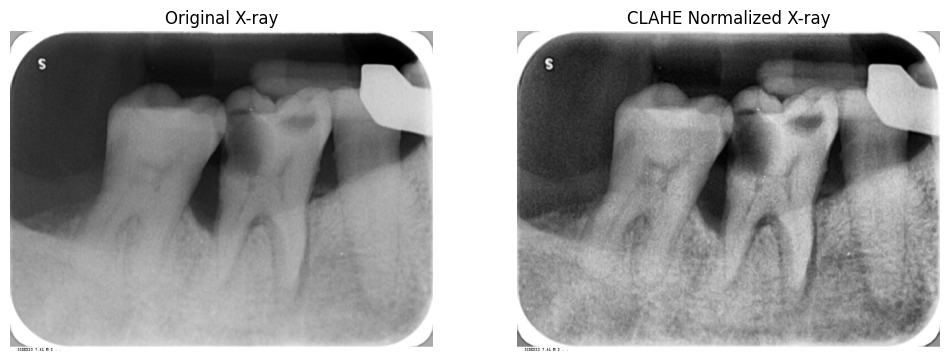

In [11]:
# Example image
sample_image_name = "1.tif"  # replace with your actual file name

# Paths
orig_path = os.path.join("/content/drive/MyDrive/Problem_teeth/Problem_teeth", sample_image_name)
norm_path = os.path.join("/content/drive/MyDrive/PROBLEM_normalized", sample_image_name)

# Load images as grayscale
orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
norm_img = cv2.imread(norm_path, cv2.IMREAD_GRAYSCALE)

# Plot side by side
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original X-ray")
plt.imshow(orig_img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("CLAHE Normalized X-ray")
plt.imshow(norm_img, cmap="gray")
plt.axis("off")

plt.show()

In [12]:
classes = ["NO_PROBLEM", "PROBLEM"]
source_folders = {
    "NO_PROBLEM": "/content/drive/MyDrive/NO_PROBLEM_normalized",
    "PROBLEM": "/content/drive/MyDrive/PROBLEM_normalized"
}

splits = ["train_norm", "test_norm", "val_norm"]
for split in splits:
    for cls in classes:
        os.makedirs(f"dataset/{split}/{cls}", exist_ok=True)

def split_and_copy_images(cls_name):
    source_folder = source_folders[cls_name]

    # Collect image files
    image_files = [
        os.path.join(source_folder, f)
        for f in os.listdir(source_folder)
        if f.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg"))
    ]

    # Split: train 70%, temp 30%
    train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
    # Split temp: val 50%, test 50% → 15% val / 15% test
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    def copy_as_png(file_list, dest_folder):
        for f in file_list:
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠️ Failed to read {f}")
                continue
            base_name = os.path.basename(f).rsplit('.', 1)[0] + ".png"
            out_path = os.path.join(dest_folder, base_name)
            cv2.imwrite(out_path, img)

    # Copy
    copy_as_png(train_files, f"dataset/train_norm/{cls_name}/")
    copy_as_png(test_files, f"dataset/test_norm/{cls_name}/")
    copy_as_png(val_files, f"dataset/val_norm/{cls_name}/")

    print(f"{cls_name}: Train={len(train_files)} | Test={len(test_files)} | Val={len(val_files)}")

print("=== Splitting dataset into train/val/test and converting to PNG ===")
for cls in classes:
    split_and_copy_images(cls)

print("\n✔ Dataset split and PNG conversion complete!")

=== Splitting dataset into train/val/test and converting to PNG ===
NO_PROBLEM: Train=103 | Test=23 | Val=22
PROBLEM: Train=107 | Test=24 | Val=23

✔ Dataset split and PNG conversion complete!


In [13]:
dataset_base = "/content/dataset"  # your dataset folder
extensions = (".png")

def check_images(dataset_dir):
    for root, dirs, files in os.walk(dataset_dir):
        img_files = [f for f in files if f.lower().endswith(extensions)]
        print(f"Folder: {root} | Images: {len(img_files)} | Subfolders: {len(dirs)}")

# Run check
check_images(dataset_base)

Folder: /content/dataset | Images: 0 | Subfolders: 6
Folder: /content/dataset/train_norm | Images: 0 | Subfolders: 2
Folder: /content/dataset/train_norm/NO_PROBLEM | Images: 103 | Subfolders: 0
Folder: /content/dataset/train_norm/PROBLEM | Images: 107 | Subfolders: 0
Folder: /content/dataset/test_norm | Images: 0 | Subfolders: 2
Folder: /content/dataset/test_norm/NO_PROBLEM | Images: 23 | Subfolders: 0
Folder: /content/dataset/test_norm/PROBLEM | Images: 24 | Subfolders: 0
Folder: /content/dataset/test | Images: 0 | Subfolders: 2
Folder: /content/dataset/test/Problem_teeth | Images: 0 | Subfolders: 0
Folder: /content/dataset/test/No_problem_teeth | Images: 0 | Subfolders: 0
Folder: /content/dataset/val_norm | Images: 0 | Subfolders: 2
Folder: /content/dataset/val_norm/NO_PROBLEM | Images: 22 | Subfolders: 0
Folder: /content/dataset/val_norm/PROBLEM | Images: 23 | Subfolders: 0
Folder: /content/dataset/val | Images: 0 | Subfolders: 2
Folder: /content/dataset/val/Problem_teeth | Images: 

In [14]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [15]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(len(pred[0]))
  print(tf.argmax(pred))
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img, cmap="gray")
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [16]:
# Directories
train_dir = '/content/dataset/train_norm'
val_dir = '/content/dataset/val_norm'
test_dir = '/content/dataset/test_norm'

In [17]:
# 1. Data augmentation
# -------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=8,
    class_mode='binary',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

Found 210 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [19]:
def view_random_images(target_dir, target_class, num_images=4):

    target_dir = target_dir.rstrip("/")

    base_folder = os.path.join(target_dir, target_class)

    # If nested folder with same name exists:
    nested_folder = os.path.join(base_folder, target_class)
    if os.path.exists(nested_folder):
        print(f"📁 Nested folder detected → using: {nested_folder}")
        target_folder = nested_folder
    else:
        target_folder = base_folder

    all_images = [f for f in os.listdir(target_folder)
                  if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif"))]

    if len(all_images) == 0:
        print(f"❌ No images found in {target_folder}")
        return []

    if num_images > len(all_images):
        print(f"⚠️ Only {len(all_images)} images available. Showing all.")
        num_images = len(all_images)

    random_images = random.sample(all_images, num_images)
    print("Selected:", random_images)

    plt.figure(figsize=(10, 10))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(target_folder, img_name)

        img = mpimg.imread(img_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(img_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
view_random_images(train_dir, "NO_PROBLEM", 4)
view_random_images(train_dir, "PROBLEM", 4)
view_random_images(test_dir, "NO_PROBLEM", 4)
view_random_images(test_dir, "PROBLEM", 4)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# 2. Define a small CNN
# -------------------------------
model_1 = Sequential([
    Conv2D(16, 3, activation='relu', padding='same', input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(2),
    Dropout(0.3),

    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPool2D(2),
    Dropout(0.3),

    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D(2),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3. Callbacks
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# 4. Train
# -------------------------------
history_1 = model_1.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # EarlyStopping will stop when needed
    callbacks=[early_stop, reduce_lr]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 597ms/step - accuracy: 0.6174 - loss: 3.8353 - val_accuracy: 0.5111 - val_loss: 1.8130 - learning_rate: 1.0000e-04
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.5053 - loss: 1.8043 - val_accuracy: 0.5111 - val_loss: 1.7264 - learning_rate: 1.0000e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.5447 - loss: 1.7066 - val_accuracy: 0.5111 - val_loss: 1.6698 - learning_rate: 1.0000e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.5419 - loss: 1.6548 - val_accuracy: 0.5111 - val_loss: 1.6301 - learning_rate: 1.0000e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.5106 - loss: 1.6238 - val_accuracy: 0.5111 - val_loss: 1.5985 - learning_rate: 1.0000e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - accuracy: 0.5083 - loss: 1.5894 - val_accuracy: 0.5111 - val_loss: 1.5713 - learning_rate: 1.0000e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy:

In [22]:
# 5. Evaluate on test set
# -------------------------------
test_loss, test_acc = model_1.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - accuracy: 0.7505 - loss: 0.9961
Test Loss: 0.9524, Test Accuracy: 0.6809


In [24]:
model_2 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, 3, activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_data,
    epochs=5,           # you can increase later
    validation_data=test_data
)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 516ms/step - accuracy: 0.4704 - loss: 0.7781 - val_accuracy: 0.5106 - val_loss: 0.6930
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.4824 - loss: 0.6949 - val_accuracy: 0.5106 - val_loss: 0.6931
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.5482 - loss: 0.6930 - val_accuracy: 0.5106 - val_loss: 0.6931
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.5530 - loss: 0.6928 - val_accuracy: 0.5106 - val_loss: 0.6931
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5106 - val_loss: 0.6931


In [26]:
model_2.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.2527 - loss: 0.6951


[0.6930723190307617, 0.5106382966041565]

In [27]:
# Base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze initially

# Custom top
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model_3 = Model(inputs=base_model.input, outputs=output)

# Compile the full model
model_3.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
history_3 = model_3.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5111 - loss: 0.6932 - val_accuracy: 0.5111 - val_loss: 0.6928
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.5117 - loss: 0.6922 - val_accuracy: 0.5111 - val_loss: 0.6928
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.4498 - loss: 0.6940 - val_accuracy: 0.5111 - val_loss: 0.6928
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.5111 - val_loss: 0.6928
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.4534 - loss: 0.6951 - val_accuracy: 0.4889 - val_loss: 0.6934


In [30]:
# Unfreeze last 50 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with smaller LR
model_3.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_finetune = model_3.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.4940 - loss: 0.6999 - val_accuracy: 0.5778 - val_loss: 0.6929
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.4749 - loss: 0.7122 - val_accuracy: 0.5111 - val_loss: 0.6928
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.5321 - loss: 0.6900 - val_accuracy: 0.5111 - val_loss: 0.6927
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.5296 - loss: 0.6800 - val_accuracy: 0.5111 - val_loss: 0.6927
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.5136 - loss: 0.7007 - val_accuracy: 0.5111 - val_loss: 0.6927


In [69]:
!git config --global user.name "Your Name"
!git config --global user.email "zignut1035@gmail.com"

[main 123bd61] Commit first tooth thesis
 1208 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 NO_PROBLEM_normalized/1.tif
 create mode 100644 NO_PROBLEM_normalized/10.tif
 create mode 100644 NO_PROBLEM_normalized/100.tif
 create mode 100644 NO_PROBLEM_normalized/101.tif
 create mode 100644 NO_PROBLEM_normalized/102.tif
 create mode 100644 NO_PROBLEM_normalized/103.tif
 create mode 100644 NO_PROBLEM_normalized/104.tif
 create mode 100644 NO_PROBLEM_normalized/105.tif
 create mode 100644 NO_PROBLEM_normalized/106.tif
 create mode 100644 NO_PROBLEM_normalized/107.tif
 create mode 100644 NO_PROBLEM_normalized/108.tif
 create mode 100644 NO_PROBLEM_normalized/109.tif
 create mode 100644 NO_PROBLEM_normalized/11.tif
 create mode 100644 NO_PROBLEM_normalized/110.tif
 create mode 100644 NO_PROBLEM_normalized/111.tif
 create mode 100644 NO_PROBLEM_normalized/112.tif
 create mode 100644 NO_PROBLEM_normalized/113.tif
 create mode 100644 NO_PROBLEM_normalized/114.tif
 create mo

In [71]:
!cp /content/drive/MyDrive/Colab Notebooks/Tooth_mobility.ipynb /content/Tooth-Mobility/


cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/Tooth_mobility.ipynb': No such file or directory


In [74]:
!ls "/content/drive/MyDrive/Colab Notebooks"


 AD3BFE4E-523B-4372-8AE1-8DDE0647B71D.png	   Problem_teeth
'APPLICATION FORM (1).pdf'			   tensorflow
'APPLICATION FORM.pdf'				   TOR8.gdoc
 Artistic					   Untitled0.ipynb
'Colab Notebooks'				   Untitled1.ipynb
 dataset_auto_cropped				   Untitled2.ipynb
 Fortum_sopimusvahvistus_77_7764301_16068018.pdf   Untitled3.ipynb
'Getting started.pdf'				   Untitled4.ipynb
'image (1).jpg'					   Untitled5.ipynb
'image (2).jpg'					   Untitled6.ipynb
 image.jpg					   Untitled7.ipynb
 NO_PROBLEM_normalized				   Untitled8.ipynb
 No_problem_teeth				   Untitled9.ipynb
 PROBLEM_normalized
